#Imports

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [ ]:
import joblib

#Download and Load Dataset

In [ ]:
path = kagglehub.dataset_download("ziya07/plant-health-data")

100%|██████████| 125k/125k [00:00<00:00, 57.4MB/s]

Extracting files...


In [ ]:
df = pd.read_csv(path + "/plant_health_data.csv")

In [ ]:
df.head()

,Timestamp,Plant_ID,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal,Plant_Health_Status
0,2024-10-03 10:54:53.407995,1,27.521109,22.240245,21.900435,55.291904,556.172805,5.581955,10.003650,45.806852,39.076199,35.703006,0.941402,High Stress
1,2024-10-03 16:54:53.407995,1,14.835566,21.706763,18.680892,63.949181,596.136721,7.135705,30.712562,25.394393,17.944826,27.993296,0.164899,High Stress
2,2024-10-03 22:54:53.407995,1,17.086362,21.180946,15.392939,67.837956,591.124627,5.656852,29.337002,27.573892,35.706530,43.646308,1.081728,High Stress
3,2024-10-04 04:54:53.407995,1,15.336156,22.593302,22.778394,58.190811,241.412476,5.584523,16.966621,26.180705,26.257746,37.838095,1.186088,High Stress
4,2024-10-04 10:54:53.407995,1,39.822216,28.929001,18.100937,63.772036,444.493830,5.919707,10.944961,37.898907,37.654483,48.265812,1.609805,High Stress


#Exploratory Data Analysis (EDA)

In [ ]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               1200 non-null   object 
 1   Plant_ID                1200 non-null   int64  
 2   Soil_Moisture           1200 non-null   float64
 3   Ambient_Temperature     1200 non-null   float64
 4   Soil_Temperature        1200 non-null   float64
 5   Humidity                1200 non-null   float64
 6   Light_Intensity         1200 non-null   float64
 7   Soil_pH                 1200 non-null   float64
 8   Nitrogen_Level          1200 non-null   float64
 9   Phosphorus_Level        1200 non-null   float64
 10  Potassium_Level         1200 non-null   float64
 11  Chlorophyll_Content     1200 non-null   float64
 12  Electrochemical_Signal  1200 non-null   float64
 13  Plant_Health_Status     1200 non-null   object 
dtypes: float64(11), int64(1), 

In [ ]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
          Plant_ID  Soil_Moisture  Ambient_Temperature  Soil_Temperature  \
count  1200.000000    1200.000000          1200.000000       1200.000000   
mean      5.500000      25.106918            23.999130         19.957794   
std       2.873479       8.677725             3.441561          2.932073   
min       1.000000      10.000724            18.001993         15.003710   
25%       3.000000      17.131893            21.101766         17.353027   
50%       5.500000      25.168333            23.889044         19.911473   
75%       8.000000      32.370231            27.042634         22.596851   
max      10.000000      39.993164            29.990886         24.995929   

          Humidity  Light_Intensity      Soil_pH  Nitrogen_Level  \
count  1200.000000      1200.000000  1200.000000     1200.000000   
mean     54.853165       612.637265     6.524102       30.106751   
std       8.784916       228.318853     0.581755       11.514396   
min      40.028758    

In [ ]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Timestamp                 0
Plant_ID                  0
Soil_Moisture             0
Ambient_Temperature       0
Soil_Temperature          0
Humidity                  0
Light_Intensity           0
Soil_pH                   0
Nitrogen_Level            0
Phosphorus_Level          0
Potassium_Level           0
Chlorophyll_Content       0
Electrochemical_Signal    0
Plant_Health_Status       0
dtype: int64


#Visuslize

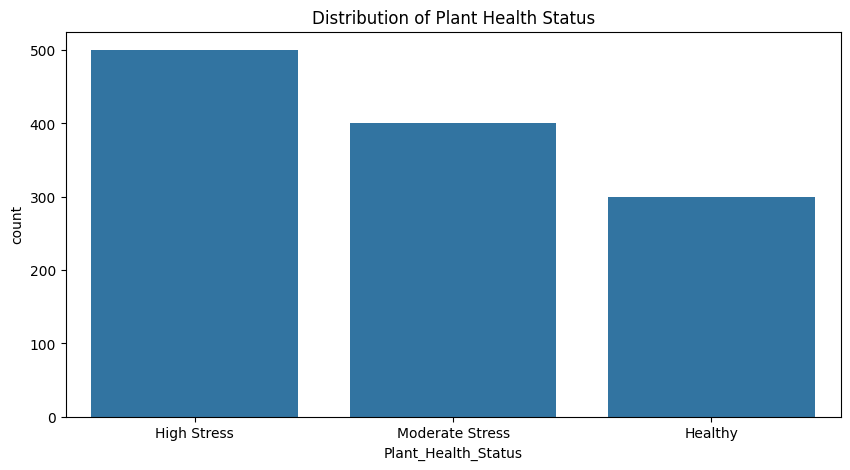

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="Plant_Health_Status", data=df)
plt.title("Distribution of Plant Health Status")
plt.show()

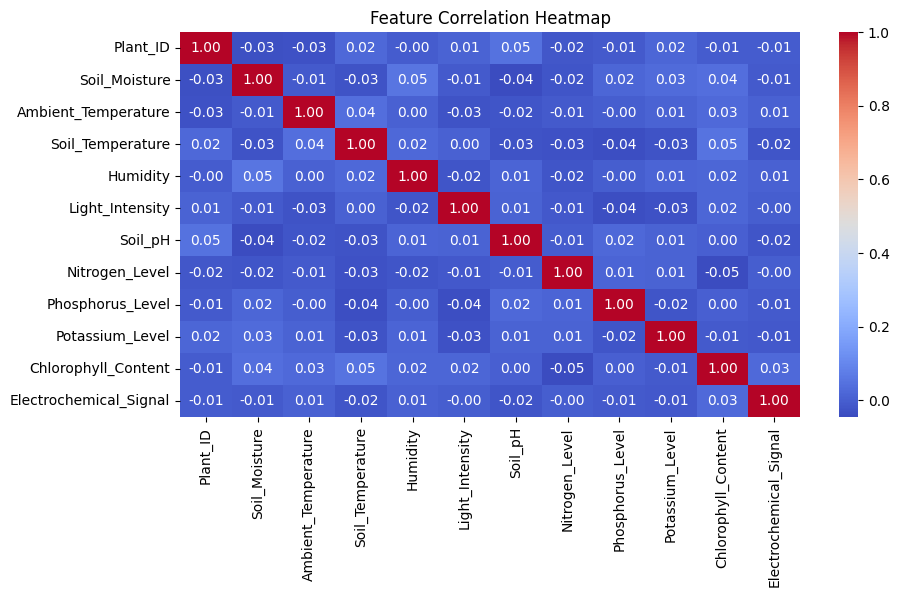

In [ ]:
numeric_df = df.select_dtypes(include=["number"])
plt.figure(figsize=(10, 5))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

#Data Preparation

In [ ]:
features = ["Soil_Moisture", "Ambient_Temperature", "Humidity", "Light_Intensity"]
target = "Plant_Health_Status"

In [ ]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

#XGBoost Model

In [ ]:
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

In [ ]:
grid_search = GridSearchCV(
    xgb.XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss"),
    param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
best_model = xgb.XGBClassifier(**grid_search.best_params_,
                               objective="multi:softmax", num_class=3,
                               use_label_encoder=False, eval_metric="mlogloss")

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

y_pred = best_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:50:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Tuned Accuracy: {accuracy * 100:.1f}%")
print(f"Precision: {precision * 100:.1f}%")
print(f"Recall: {recall * 100:.1f}%")
print(f"F1-Score: {f1 * 100:.1f}%")

Tuned Accuracy: 92.5%
Precision: 93.2%
Recall: 92.5%
F1-Score: 92.6%


#Plot accuracy

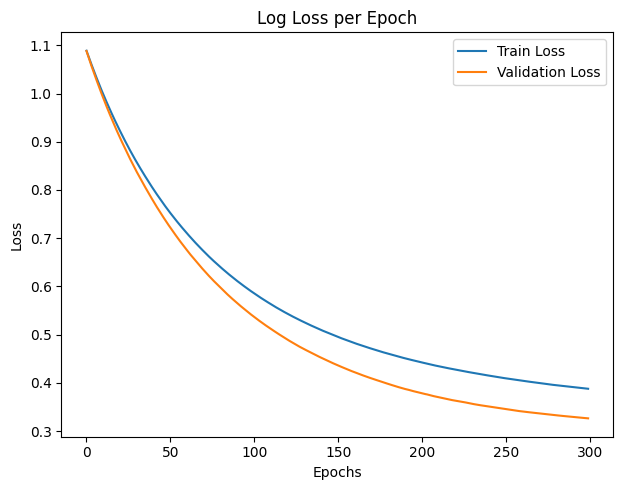

In [ ]:
results = best_model.evals_result()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['mlogloss'], label='Train Loss')
plt.plot(results['validation_1']['mlogloss'], label='Validation Loss')
plt.title('Log Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Save Model

In [ ]:
joblib.dump(best_model, "xgboost_plant_health.pkl")

['xgboost_plant_health.pkl']

In [ ]:
!cp -r ./xgboost_plant_health.pkl ./drive/MyDrive/

cp: cannot create regular file './drive/MyDrive/': No such file or directory


#Load Model and Model Info

In [ ]:
loaded_model = joblib.load("xgboost_plant_health.pkl")

In [ ]:
print(loaded_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)


In [ ]:
print(loaded_model.get_params())

{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 3, 'use_label_encoder': False}


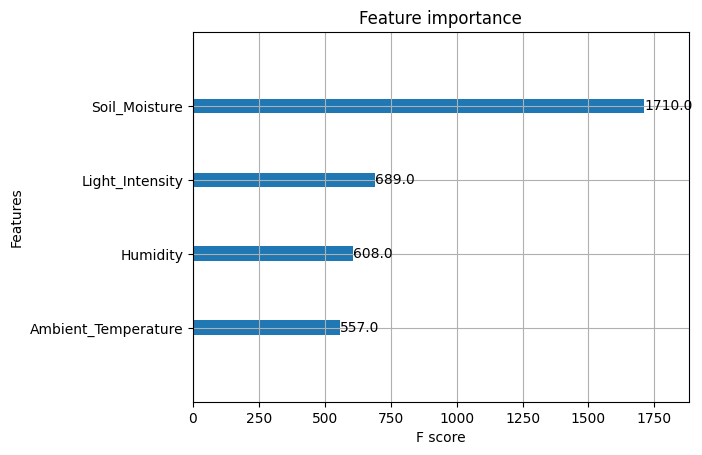

In [ ]:
xgb.plot_importance(loaded_model)
plt.show()